# Coin-flip puzzle
*Solution by Cian Galvin*

Alice &amp; Bob flip coins. Alice gets points for HH. Bob gets points for HT. Who wins in a 100-flip game?

https://twitter.com/littmath/status/1769044719034647001

https://www.reddit.com/r/theydidthemath/comments/1bgnbnt/request_whod_get_more_points/

**Daniel Litt's challenge:**

Flip a fair coin 100 times—it gives a sequence of heads (H) and tails (T). For each HH in the sequence of flips, Alice gets a point; for each HT, Bob does, so e.g. for the sequence THHHT Alice gets 2 points and Bob gets 1 point. Who is most likely to win?

Poll results:
 - Alice 26.3%
 - Bob 10.2%
 - Equally likely 42.8%
 - See results 20.7%

Actual result:
Bob wins ~**48.6%** of games, Alice wins ~**45.8%**. 5.6% of games are ties

Of the ~41k people who choose an answer (Alice, Bob, Equally likely), 87.1% voted against Bob winning

In [1]:
# Renormalization without "See results" response
votes = [26.3, 10.2, 42.8]

renorm = [round(100 * x / sum(votes), 1) for x in votes]

incorrect_answers = 100 - renorm[1]
renorm, incorrect_answers

([33.2, 12.9, 54.0], 87.1)

## Imports

In [2]:
import random
import re

import pandas as pd
from matplotlib import pyplot as plt

## Simulation & score calculation
For this simulation, I am treating a Heads as a 1 and a Tails as a 0. This allows me to generate a game of arbitrary length with a single random number written in binary

In [3]:
coin_flips = 100  # Coinflips per game
trial_count = int(1e6)  # How many games/trials to generate

# This number in binary is a string of 1's, the absolute ideal case for Alice
all_heads = (2**coin_flips) - 1

# Generate a zero-padded 100-digit binary number for each trial
trials = [f"{random.randint(0, all_heads):0100b}" for _ in range(trial_count)]
trials[:5]

['0110011011100001010100011110101100010110111100001001101111000101010001101101101010011110101010100001',
 '1011100010011111101101001001110111000110000110110001000011001010010101111001011100000011001001110010',
 '0001011010100011100111111001000111010011000011010001011010100101011101111101010000100010111100000000',
 '1001010000110000101101111111000111101101100010110000010110110001110111110011100111100110111101001101',
 '1010011111100010001111001111000010111100110001110110111011001110110000001110111001110111000101011001']

In [4]:
# Generate CSV for sharing

# (
#     pd.Series(trials)
#     .str.replace("1", "H")
#     .str.replace("0", "T")
#     .to_csv(
#         "simulated_games.csv",
#         index=False,
#         header=False,
#     )
# )

In [5]:
df = pd.DataFrame(trials, columns=["trial"])

# Alice gets points from overlapping sequences, so two points from HHH.

# Using lookahead regular expression
# df["alice_points"] = df["trial"].apply(lambda x: len(re.findall("(?=11)", x)))

# Using list split method - faster?
df["alice_points"] = df["trial"].apply(
    lambda x: sum(len(y) - 1 for y in x.split("0") if y)
)

# Bob's points are easier to calculate
df["bob_points"] = df["trial"].str.count("10")


# Defining win-loss-tie columns
df["alice_wins"] = df["alice_points"] > df["bob_points"]
df["bob_wins"] = df["alice_points"] < df["bob_points"]
df["tie"] = df["alice_points"] == df["bob_points"]

df.head()

,trial,alice_points,bob_points,alice_wins,bob_wins,tie
0,0110011011100001010100011110101100010110111100...,22,28,False,True,False
1,1011100010011111101101001001110111000110000110...,24,25,False,True,False
2,0001011010100011100111111001000111010011000011...,22,25,False,True,False
3,1001010000110000101101111111000111101101100010...,32,23,True,False,False
4,1010011111100010001111001111000010111100110001...,33,22,True,False,False


## Declaring the winner

In [10]:
# Win-rate percentage
df[["alice_wins", "bob_wins", "tie"]].mean().mul(100).round(1)

alice_wins    45.9
bob_wins      48.5
tie            5.6
dtype: float64

## Further examination

In [12]:
df.describe()

,alice_points,bob_points
count,1000000.000000,1000000.000000
mean,24.756081,24.745856
std,5.553401,2.514106
min,3.000000,13.000000
25%,21.000000,23.000000
50%,25.000000,25.000000
75%,28.000000,26.000000
max,56.000000,37.000000


Alice & Bob both have the same mean score to three significant figures and the same median score. The standard deviation of Alice's score is much higher.

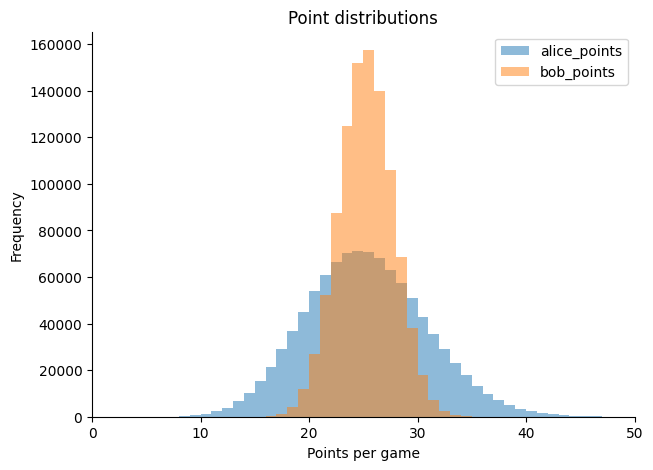

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))

df[["alice_points", "bob_points"]].plot.hist(
    alpha=0.5,
    bins=range(0, 51),
    ax=ax,
)

ax.set(
    title="Point distributions",
    xlabel="Points per game",
    xlim=[0, 50],
)
ax.spines[["right", "top"]].set_visible(False)

plt.show()

Examining how the win-rate esimation changes with the number of trials, it appears to be quite stable from 400k trials onwards

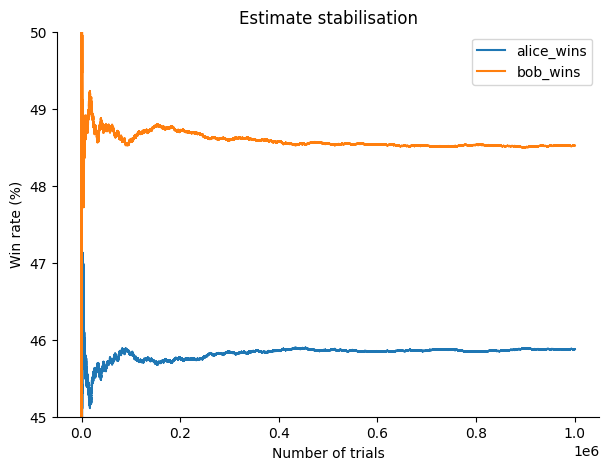

In [8]:
fig, ax = plt.subplots(figsize=(7, 5))

df[["alice_wins", "bob_wins"]].mul(100).expanding().mean().plot.line(ax=ax)

ax.set(
    title="Estimate stabilisation",
    xlabel="Number of trials",
    ylabel="Win rate (%)",
    ylim=[45, 50],
)

ax.spines[["right", "top"]].set_visible(False)

plt.show()